# Note to Participants
The code is adapted from an implementation from https://github.com/huggingface/transformers/issues/28778, utilizing a custom loss function and is meant to broadly point participants in the general direction of what it would take to fine-tune the OWL-ViT model. As such, teams are strongly encouraged to explore, change, and improve the training script that follows.

In [1]:
import os
# from pathlib import Path
import logging
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from PIL import ImageDraw
from PIL import Image as PILImage

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from datasets import load_dataset, Dataset, DatasetDict, Image, Sequence, Features, Value, Array2D, ClassLabel
from transformers import AutoImageProcessor, AutoProcessor, AutoModelForZeroShotObjectDetection, TrainingArguments, Trainer, pipeline

import torch
import albumentations

from HungarianMatcher import HungarianMatcher
from SetCriterion import SetCriterion
from CustomTrainer import CustomTrainer

# Library

In [2]:
torch.cuda.empty_cache()
# torch.multiprocessing.set_start_method('spawn')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Logging

In [3]:
# Configure logging (example for `logging` module)
logging.basicConfig(
    level=logging.WARNING,  # Adjust as needed (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)


# References
- https://github.com/huggingface/transformers/issues/28778
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

Also helpful, but through google's research scenic repo
- https://github.com/google-research/scenic/issues/542

And also, nvidia implement
- https://github.com/NVIDIA-AI-IOT/nanoowl

# Data

## Dataset Summary

In [4]:
df = pd.read_json('../data/vlm.jsonl', lines=True)
df["image_id"] = df.index

df['width'] = df['image'].apply(lambda x: PILImage.open('../data/images/' + x).size)
df['height'] = df['width'].apply(lambda x: x[1])
df['width'] = df['width'].apply(lambda x: x[0])

id_len = 0
def id_label(x):
	global id_len
	res = [i for i in range(id_len, id_len + len(x))]
	id_len += len(x)
	return res
def wrap_data(x):
	dct = {"id":id_label(x), 
		"area":[i['bbox'][2] * i['bbox'][3] for i in x],
		"bbox":[i['bbox'] for i in x],
		"category":[i for i in range(len(x))], 
		"caption":[i['caption'] for i in x]
	}
	return dct


df['objects'] = df['annotations'].apply(lambda x: wrap_data(x))
df = df[['image_id', 'image', 'width', 'height', 'objects']]
df

image_id           image  width  height  \
0            0     image_0.jpg   1520     870   
1            1     image_1.jpg   1520     870   
2            2     image_2.jpg   1520     870   
3            3     image_3.jpg   1520     870   
4            4     image_4.jpg   1520     870   
...        ...             ...    ...     ...   
5102      5102  image_5102.jpg   1520     870   
5103      5103  image_5103.jpg   1520     870   
5104      5104  image_5104.jpg   1520     870   
5105      5105  image_5105.jpg   1520     870   
5106      5106  image_5106.jpg   1520     870   

                                                objects  
0     {'id': [0, 1, 2, 3], 'area': [7296, 672, 4864,...  
1     {'id': [4, 5, 6, 7, 8, 9], 'area': [2304, 6912...  
2     {'id': [10, 11, 12, 13, 14, 15], 'area': [2912...  
3     {'id': [16, 17, 18, 19, 20, 21, 22], 'area': [...  
4     {'id': [23, 24, 25], 'area': [3360, 1152, 3648...  
...                                                 ...  
5102  {'id': [27886, 27887, 27888, 27889, 27890, 278...  
5103  {'id': [27894, 27895, 27896, 27897, 27898, 278...  
5104  {'id': [27901, 27902, 27903, 27904, 27905], 'a...  
5105  {'id': [27906, 27907, 27908], 'area': [1584, 2...  
5106  {'id': [27909, 27910, 27911, 27912], 'area': [...  

[5107 rows x 5 columns]

In [5]:
# def get_Categories(df):
# 	# df = pd.read_json('../data/vlm.jsonl', lines=True)
# 	categories = list(filter(lambda x: x != None, pd.DataFrame([i for i in list(df['objects'].apply(lambda x: [i['caption'] for i in x]))]).to_numpy().flatten()))
# 	num_cat = len(categories)
# 	categories = pd.DataFrame(categories)
# 	categories.drop_duplicates(inplace=True)
# 	categories = categories.values.flatten().tolist()
# 	id2label = {index: x for index, x in enumerate(categories, start=0)}
# 	label2id = {v: k for k, v in id2label.items()}
# 	return len(id2label)
# get_Categories(df)

In [6]:
def get_Train_Test(df):
	train_set = {
		"image_id": [],
		"image": [],
		"width": [],
		"height": [],
		"objects": [],
	}

	test_set = {
		"image_id": [],
		"image": [],
		"width": [],
		"height": [],
		"objects": [],
	}

	def add_data(data, start=0, end=10):
		for i, row in df.loc[start:end].iterrows():
			for k, v in row.items():
				if k == 'image':
					data[k].append(PILImage.open(os.path.join('../data/images/', row["image"])))
				else:
					data[k].append(row[k])
		return data

	def wrap_Dataset(data):
		wrapped = Dataset.from_dict(data, features=Features({
				"image_id": Value(dtype="int32", id=None),
				"image": Image(),
				"width": Value(dtype="int32", id=None),
				"height": Value(dtype="int32", id=None),
				"objects": Sequence(feature=({
					"id": Value(dtype="int32", id=None),
					"area": Value(dtype="int32", id=None),
					"bbox": Sequence(Value('float32')),
					"category": Value(dtype="int32", id=None),
					"caption": Value(dtype="string", id=None),
				})),
			})
		)
		return wrapped

	train = wrap_Dataset(add_data(train_set, start=0, end=8))
	test = wrap_Dataset(add_data(test_set, start=8, end=10))
		

	
	return train, test

train, test = get_Train_Test(df)
train, test

vlm_dataset = DatasetDict()
vlm_dataset['train'] = train
vlm_dataset['test'] = test
vlm_dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 9
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
})

One common problem with datasets for object detection is bounding boxes that “stretch” beyond the edge of the image. Such “runaway” bounding boxes can raise errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset. To keep things simple in this guide, we remove these images from the data.

Also, lets limit to only 100 training images.

In [7]:
# remove image with bounding boxes outstreched
# remove_idx = [590, 821, 822, 875, 876, 878, 879]
remove_idx = []
train_keep = [i for i in range(len(vlm_dataset["train"])) if i not in remove_idx]
test_keep = [i for i in range(len(vlm_dataset["test"])) if i not in remove_idx]

# limit to 100 images
# train_keep = train_keep[0:200]
# test_keep = test_keep[0:10]
vlm_dataset["train"] = vlm_dataset["train"].select(train_keep)
vlm_dataset["test"] = vlm_dataset["test"].select(test_keep)
print(len(vlm_dataset["train"]), len(vlm_dataset["test"]))

9 3


illustrate one of the image

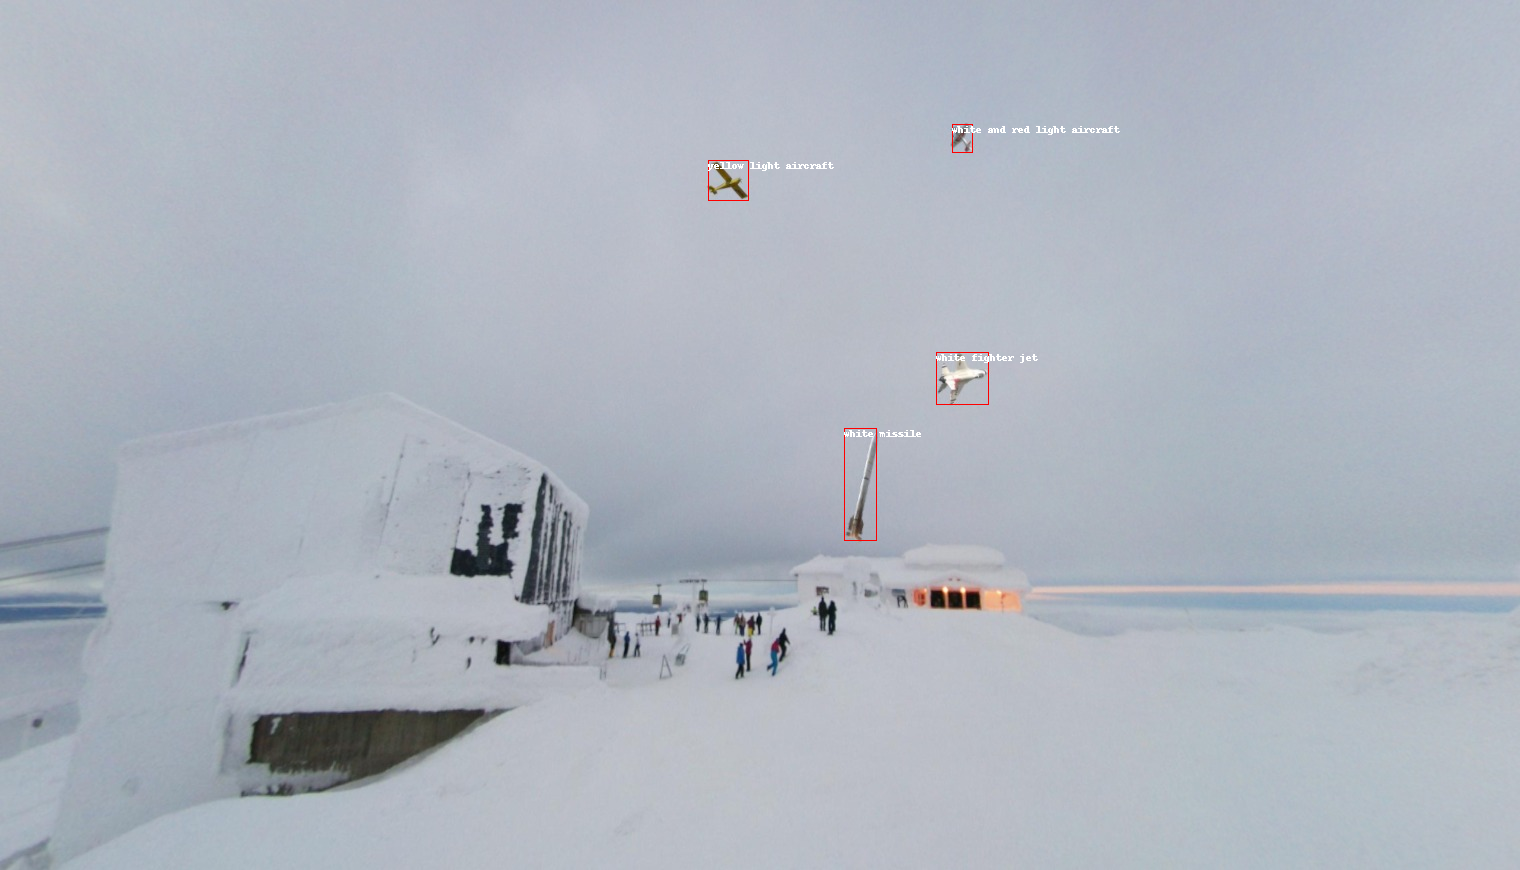

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw
img_no = 0

image = vlm_dataset["test"][img_no]["image"]
annotations = vlm_dataset["test"][img_no]["objects"]
draw = ImageDraw.Draw(image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), annotations["caption"][class_idx], fill="white")

image

# Model & Processor

In [9]:
from transformers import AutoImageProcessor
from transformers import AutoProcessor
from sentence_transformers import SentenceTransformer
# using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlv2-base-patch16-ensemble"
processor = AutoProcessor.from_pretrained(checkpoint)

from transformers import AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    # id2label=id2label,
    # label2id=label2id,
    # ignore_mismatched_sizes=True,
)
text_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
model.to(device)

print("loaded!")

# other better checkpoints, but would run out of memory with current T4 instance for fine-tuning, could be use for inference
# google/owlv2-base-patch16
# google/owlv2-large-patch14-finetuned
# google/owlv2-base-patch16-ensemble
# while with significant better performance, would run into OOM (Out of memory)

c:\Users\Keck\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loaded!


## Testing raw owl-vit model on image data
- via pipeline

[{'scores': tensor([0.4381, 0.4488, 0.4697], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'boxes': tensor([[949.4861, 123.6321, 972.2774, 152.4875],
        [706.6538, 161.0354, 747.5674, 199.2770],
        [936.0200, 351.4899, 987.3368, 404.9062]], device='cuda:0')}]


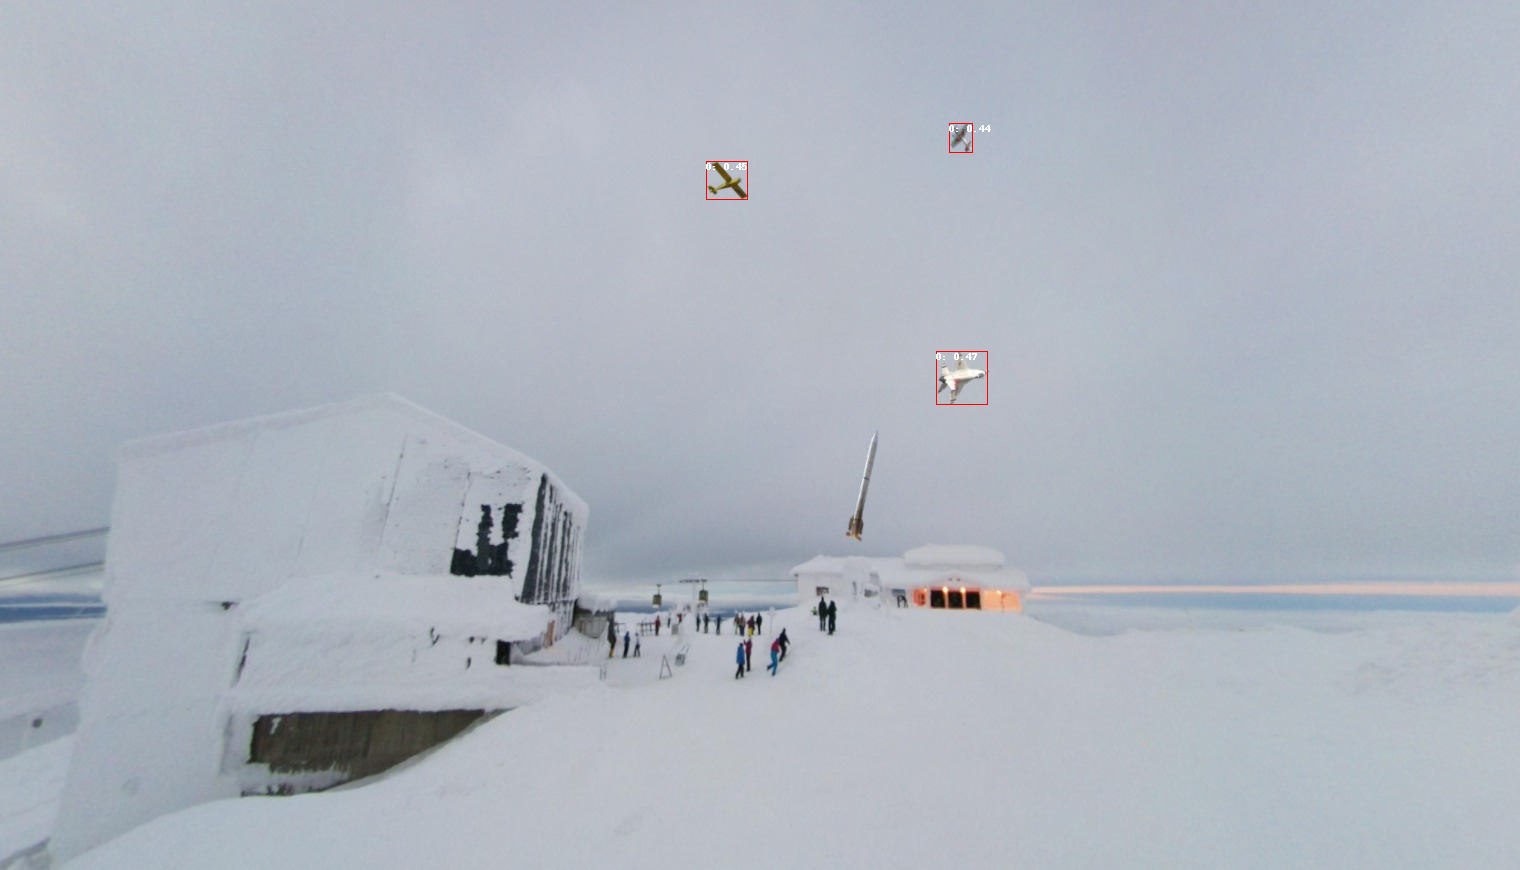

In [10]:
from transformers import pipeline
import albumentations

img_no = 0

transform_test = albumentations.Compose(
    [
        albumentations.Resize(960, 960),
    ]
)
detector = pipeline(model=checkpoint, task="zero-shot-object-detection", device=0) #checkpoint

model.eval()

image = vlm_dataset["test"][img_no]["image"]
with torch.inference_mode():
    image = np.array(image.convert("RGB"))[:, :, ::-1]
    inputs = processor(images=image, text=['jet'], return_tensors="pt").to(device)
    predictions = model(**inputs)
    classes = predictions["logits"].shape[-1]
    predictions = processor.post_process_object_detection(
            predictions, threshold=0.4, target_sizes=torch.tensor([[870,1520]])
        )
    # predictions = detector(
    #     image,
    #     candidate_labels=['fighter jet', 'red commercial jet', 'missile', 'drone', 'helicopter', 'light aircraft', "cargo plane","background"],
    #     threshold=0.7,
    #     top_k=8
    # )
print(predictions)


image = vlm_dataset["test"][img_no]["image"]
draw = ImageDraw.Draw(image)

for prediction in predictions:
    # boxes = [prediction["boxes"][torch.argmax(prediction["scores"])]]
    # labels = [prediction["labels"][torch.argmax(prediction["scores"])]]
    # scores = [prediction["scores"][torch.argmax(prediction["scores"])]]
    boxes = prediction["boxes"]
    labels = prediction["labels"]
    scores = prediction["scores"]

    for box, label, score in zip(boxes, labels, scores):
        if label == 1:
            continue
        xmin, ymin, xmax, ymax = box
        xmin = xmin.item()
        xmax = xmax.item()
        ymin = ymin.item()
        ymax = ymax.item()
        # print(xmin, ymin, xmax, ymax)
        draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
        draw.text((xmin, ymin), f"{label}: {round(score.item(),2)}", fill="white")

image

# Helper
- prestransform the images and also setup the datasets

In [11]:
transform = albumentations.Compose(
    [
        #Fixed to be consistent with the resizing that OwlV2 Processor does
        albumentations.Resize(960, 960),
        albumentations.GaussNoise(var_limit=(100.0,300.0), p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories, text_labels = [], [], [], [], []

    for image, objects in zip(examples["image"], examples["objects"]):

        image = np.array(image.convert("RGB"))[:, :, ::-1]

        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"], caption=objects["caption"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        text_labels.append(out["caption"])

    with torch.inference_mode():
        text_embeds = [text_model.encode(labels) for labels in text_labels]
            
    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    image_data = processor(text=text_labels, images=images, return_tensors="pt")

    labels_data = image_processor(images=images, annotations=targets, return_tensors="pt", do_resize=False)

    for key in ["input_ids", "attention_mask"]:
        image_data[key] = image_data[key].unsqueeze(0)

    for i, embeddings in enumerate(text_embeds):
        labels_data["labels"][i].update(embeddings=embeddings[labels_data["labels"][i]["class_labels"]])

    image_data.update(labels=labels_data["labels"])

    return image_data

# transforming a batch
def transform_aug_ann_labels(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    processed_data = image_processor(images=images, annotations=targets, return_tensors="pt")

    return processed_data

def collate_fn(batch):
    # print([item["input_ids"] for item in batch])
    input_ids = torch.stack([item["input_ids"] for item in batch]).int()
    input_ids = input_ids.to(device)
    attention_mask = torch.stack([item["attention_mask"] for item in batch]).int()
    attention_mask = attention_mask.to(device)
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    pixel_values = pixel_values.to(device)
    labels = []
    for item in batch:
        for (key, value) in item["labels"].items():
            item["labels"][key] = torch.Tensor(value).to(device)
        labels.append(item["labels"])

    batch = {}
    batch["input_ids"] = input_ids
    batch["attention_mask"] = attention_mask
    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

## Encoding the data into Dataset

In [12]:
train_dataset = vlm_dataset["train"].with_transform(transform_aug_ann)
train_dataset.features

test_dataset = vlm_dataset["test"].with_transform(transform_aug_ann)
test_dataset.features

{'image_id': Value(dtype='int32', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int32', id=None), 'area': Value(dtype='int32', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'category': Value(dtype='int32', id=None), 'caption': Value(dtype='string', id=None)}, length=-1, id=None)}

# Putting it together

To compute the custom loss we defined, we need to create a custom Trainer that inherits from the Hugging Face Trainer class. This will allow us to override the compute_loss method and implement our custom loss calculation.

In [13]:
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="local/owlv2_patch16_ft_captioned_exp",
    per_device_train_batch_size=1,
    # per_device_eval_batch_size=4,
    gradient_checkpointing=True,
    num_train_epochs=20,
    fp16=True,
    # fp16_full_eval=True,
    # evaluation_strategy="steps",
    save_steps=5000,
    dataloader_num_workers=0,
    # eval_steps=10,
    logging_steps=100,
    learning_rate=1e-5, #1e-5
    weight_decay=1e-4,
    save_total_limit=5,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    # gradient_accumulation_steps=16,
    push_to_hub=False,
    report_to='none', # disable wandb
    # load_best_model_at_end=True,
)

# use new trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    # eval_dataset=test_dataset,
    tokenizer=processor,
	categories=6
 )

eval_dict = trainer.train()

  0%|          | 0/180 [00:00<?, ?it/s]

c:\Users\Keck\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\Keck\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss_ce': tensor(9.3330, device='cuda:0', grad_fn=<DivBackward0>), 'loss_obj': tensor(1.1907, device='cuda:0', grad_fn=<DivBackward0>), 'loss_bbox': tensor([0.0053], device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor([0.1307], device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_ce': tensor(1.0908, device='cuda:0', grad_fn=<DivBackward0>), 'loss_obj': tensor(0.1126, device='cuda:0', grad_fn=<DivBackward0>), 'loss_bbox': tensor([0.0071], device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor([0.1576], device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_ce': tensor(2.4217, device='cuda:0', grad_fn=<DivBackward0>), 'loss_obj': tensor(0.4182, device='cuda:0', grad_fn=<DivBackward0>), 'loss_bbox': tensor([0.0118], device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor([0.1591], device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_ce': tensor(4.0251, device='cuda:0', grad_fn=<DivBackward0>), 'loss_obj': tensor(0.5398, device='cuda:0', grad_fn=<DivBackward0>), 'loss_bbox': ten

In [14]:
model_path = "local/custom_owlv2_1"
trainer.save_model(model_path)

# Evaluate
Similar with that of evaluater used in HF Object Detection, but adapted for owl vit

## Prediction

In [15]:
from PIL import ImageDraw
from transformers import pipeline

model_path = "local/custom_owlv2_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection", device=0)

finetune_prediction_dict = {}
for idx, i in enumerate(vlm_dataset['test']):
    predictions = detector(
        i["image"],
        candidate_labels=['fighter jet', 'commercial plane', 'missile', 'drone', 'helicopter', 'light aircraft', "cargo plane"],
        threshold=0.10,
        top_k=10
    )
    finetune_prediction_dict[idx] = predictions

In [16]:
from PIL import ImageDraw
from transformers import pipeline

model_path = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=model_path, task="zero-shot-object-detection", device=0)

base_prediction_dict = {}
for idx, i in enumerate(vlm_dataset['test']):
    predictions = detector(
        i["image"],
        candidate_labels=['fighter jet', 'commercial plane', 'missile', 'drone', 'helicopter', 'light aircraft', "cargo plane"],
        threshold=0.10,
        top_k=10
    )
    base_prediction_dict[idx] = predictions

In [17]:
test_dt = vlm_dataset["test"].to_pandas()

## Parser
- parsing the results and original data to that of torchmetrics mAP - https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html

In [18]:
# test_dt['objects'][0]

# def convert_data(data):
#   """
#   Converts the given dictionary into a list of dictionaries with tensors.
#   """

#   result = []
#   for i in range(len(data)):
#     # Extract data for each instance
#     # print(data[i])
#     box_list = []
#     label_list = []
#     for j in range(len(data[i]['category'])):
#         bbox = data[i]['bbox'][j]
#         category = data[i]['category'][j]

#         # Convert bbox to [x_min, y_min, x_max, y_max] format
#         x_min, y_min, w, h = bbox
#         x_max, y_max = x_min + w, y_min + h
#         box = [x_min, y_min, x_max, y_max]

#         box_list.append(box)
#         label_list.append(category)

#     # Create dictionary and append to result
#     result.append(dict(
#         boxes=torch.tensor(box_list, dtype=torch.float),
#         # scores=torch.tensor([0.0]),  # Placeholder for scores (assuming not provided)
#         labels=torch.tensor(label_list),
#     ))
#   return result

In [19]:
# def parsing_prediction(prediction_dict):
#     result = []
#     for idx in prediction_dict:
#         score_list, box_list, label_list = [], [], []
#         # print(prediction_dict[idx])
#         if prediction_dict[idx] :
#                 # for j in range(len(prediction_dict[idx])):
#             box_list.append(
#                 [prediction_dict[idx][0]['box']['xmin'],
#                  prediction_dict[idx][0]['box']['ymin'],
#                  prediction_dict[idx][0]['box']['xmax'],
#                  prediction_dict[idx][0]['box']['ymax']])
#             label_list.append(label2id[prediction_dict[idx][0]['label']])
#             score_list.append(prediction_dict[idx][0]['score'])

#             # Create dictionary and append to result
#             result.append(dict(
#                 boxes=torch.tensor(box_list, dtype=torch.float),
#                 scores=torch.tensor(score_list),  # Placeholder for scores (assuming not provided)
#                 labels=torch.tensor(label_list),
#             ))
#         else:
#             result.append(dict(
#                 boxes=torch.tensor([], dtype=torch.float),
#                 scores=torch.tensor([]),  # Placeholder for scores (assuming not provided)
#                 labels=torch.tensor([]),
#             ))

#     return result


In [20]:
# finetune_prediction_parse_dict = parsing_prediction(finetune_prediction_dict)
# base_prediction_parse_dict = parsing_prediction(base_prediction_dict)
# target = convert_data(test_dt['objects'])

### Comparison

In [21]:
# from torchmetrics.detection import MeanAveragePrecision
# metric = MeanAveragePrecision(iou_type="bbox")

# metric.update(finetune_prediction_parse_dict, target)
# metric.compute()

In [22]:
# metric.update(base_prediction_parse_dict, target)
# metric.compute()

As we examine the metrics, we notice a slight improvement in the mean Average Precision (mAP) for the fine-tuned model compared to the pre-trained model. This indicates that fine-tuning has positively impacted the model's performance.


Moreover, we can observe that there is still potential for further improvement. By:
- Increasing the number of epochs
- Conducting hyperparameter tuning
- Exploring additional optimization techniques

# Inference

## Fine-tuned model

[{'score': 0.8638086318969727, 'label': 'helicopter', 'box': {'xmin': 511, 'ymin': 108, 'xmax': 630, 'ymax': 159}}, {'score': 0.8578895330429077, 'label': 'missile', 'box': {'xmin': 703, 'ymin': 498, 'xmax': 785, 'ymax': 571}}, {'score': 0.8412007093429565, 'label': 'missile', 'box': {'xmin': 705, 'ymin': 505, 'xmax': 784, 'ymax': 574}}, {'score': 0.8294711112976074, 'label': 'helicopter', 'box': {'xmin': 506, 'ymin': 109, 'xmax': 626, 'ymax': 168}}, {'score': 0.8223481178283691, 'label': 'helicopter', 'box': {'xmin': 506, 'ymin': 104, 'xmax': 630, 'ymax': 160}}, {'score': 0.8014170527458191, 'label': 'helicopter', 'box': {'xmin': 508, 'ymin': 94, 'xmax': 634, 'ymax': 156}}, {'score': 0.7818253636360168, 'label': 'helicopter', 'box': {'xmin': 494, 'ymin': 97, 'xmax': 626, 'ymax': 160}}, {'score': 0.7709767818450928, 'label': 'missile', 'box': {'xmin': 702, 'ymin': 502, 'xmax': 773, 'ymax': 570}}]


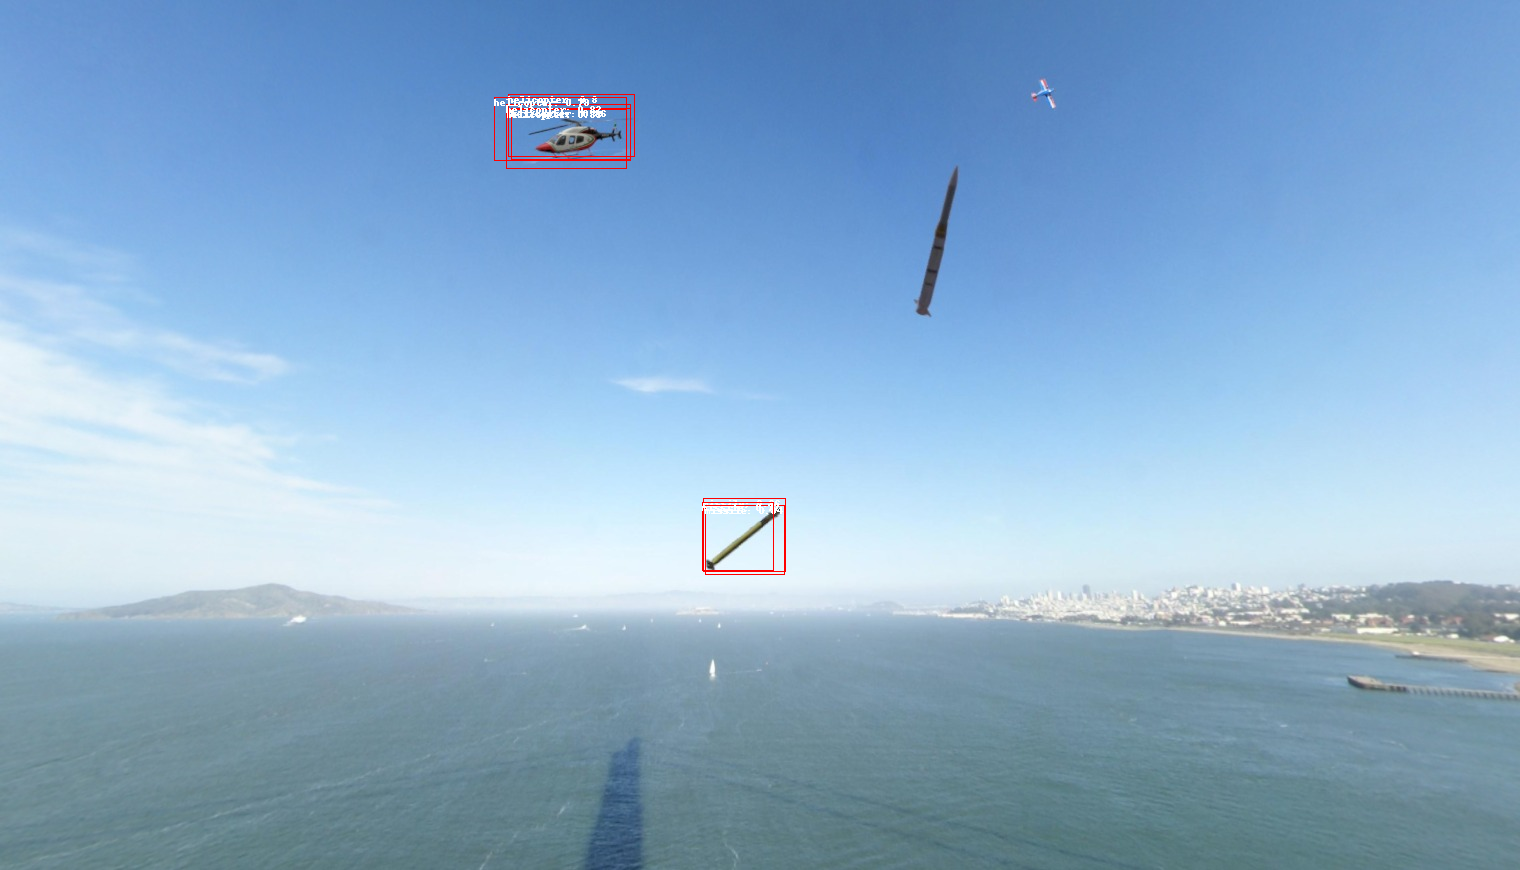

In [30]:
from PIL import ImageDraw
from transformers import pipeline


model_path = "local/custom_owlv2_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection", device=0)

image = vlm_dataset["train"][img_no]["image"]

predictions = detector(
    image,
    candidate_labels=['fighter jet', 'commercial plane', 'missile', 'drone', 'helicopter', 'light aircraft', "cargo plane"],
    threshold=0.10,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

## Raw model

[{'score': 0.8109441995620728, 'label': 'helicopter', 'box': {'xmin': 526, 'ymin': 115, 'xmax': 633, 'ymax': 162}}, {'score': 0.5161204934120178, 'label': 'drone', 'box': {'xmin': 526, 'ymin': 115, 'xmax': 633, 'ymax': 162}}, {'score': 0.506801187992096, 'label': 'missile', 'box': {'xmin': 706, 'ymin': 507, 'xmax': 780, 'ymax': 572}}, {'score': 0.468481183052063, 'label': 'light aircraft', 'box': {'xmin': 1030, 'ymin': 78, 'xmax': 1057, 'ymax': 109}}, {'score': 0.4030766785144806, 'label': 'missile', 'box': {'xmin': 918, 'ymin': 165, 'xmax': 958, 'ymax': 317}}, {'score': 0.39621880650520325, 'label': 'commercial plane', 'box': {'xmin': 1030, 'ymin': 78, 'xmax': 1057, 'ymax': 109}}, {'score': 0.37587594985961914, 'label': 'light aircraft', 'box': {'xmin': 526, 'ymin': 115, 'xmax': 633, 'ymax': 162}}, {'score': 0.32448336482048035, 'label': 'light aircraft', 'box': {'xmin': 918, 'ymin': 165, 'xmax': 958, 'ymax': 317}}]


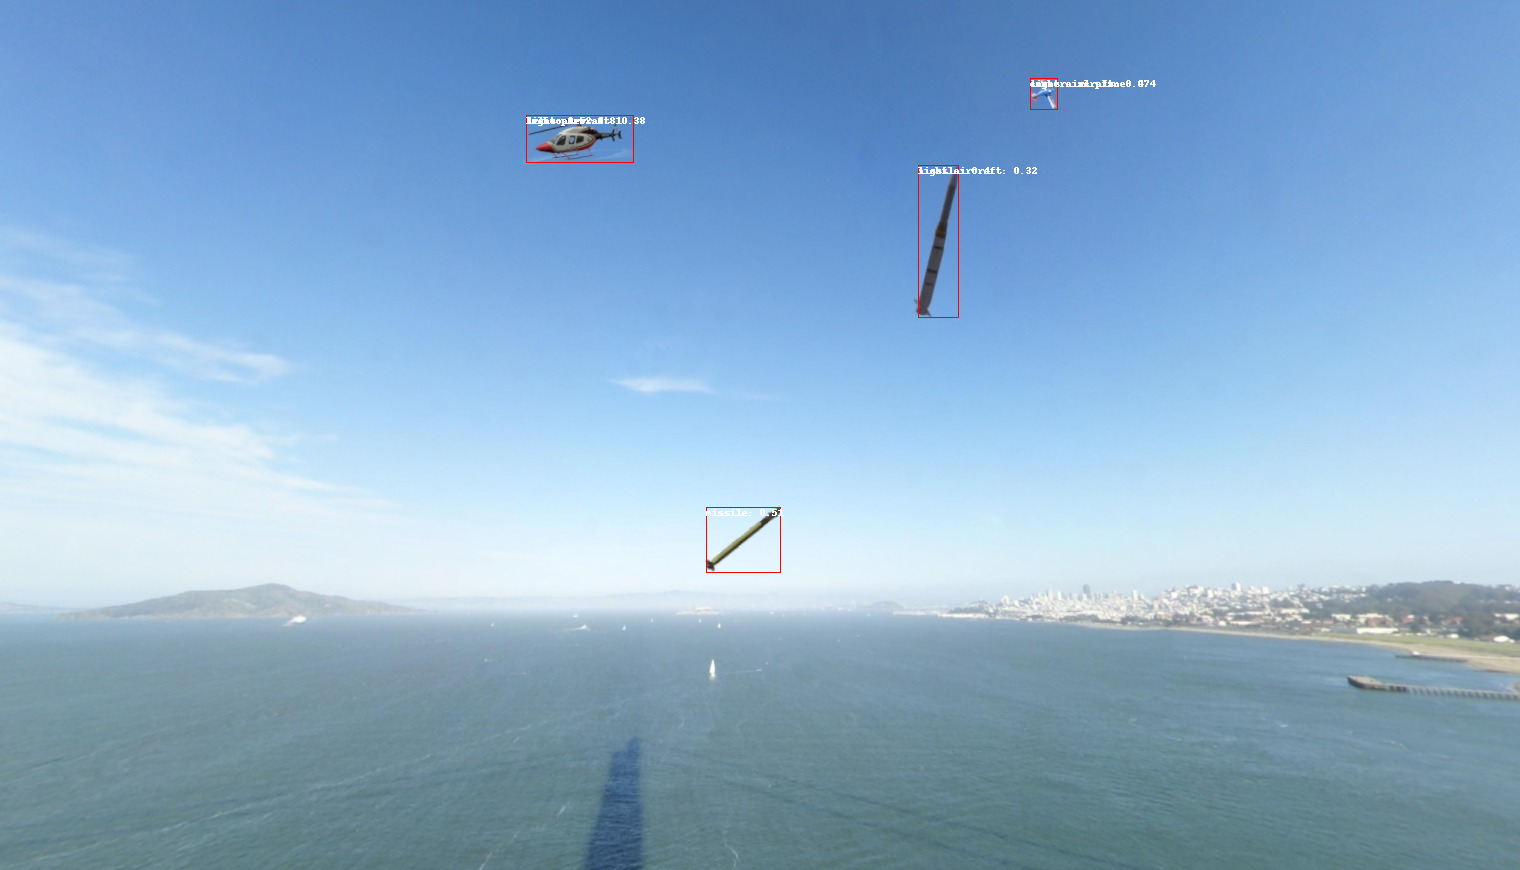

In [31]:
model_path = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=model_path, task="zero-shot-object-detection", device=0) #model_path

image = vlm_dataset["train"][img_no]["image"]

predictions = detector(
    image,
    candidate_labels=['fighter jet', 'commercial plane', 'missile', 'drone', 'helicopter', 'light aircraft', "cargo plane"],
    threshold=0.10,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image